# Clustering

In [25]:
### Question 1

In [2]:
import numpy as np
import math
import operator
from scipy.linalg import svd
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.linalg as la

C1 = np.array([[1,2],
              [0,-1]])

C2 = np.array([[0,0],
              [1,1]])

def w2_intra_dist(*args):
    """Calculating avg intra-cluster distance in clusters with 2 elements"""
    
    w_sum = 0
    n = 0
    for v in args:
        l2_v = np.linalg.norm(v[0] - v[1])
        w_sum += (l2_v/(2 * len(v))) * len(v)
        n += len(v)
    W_j = w_sum/n
    return W_j

print("Weighted average intra-cluster distance: ", w2_intra_dist(C1, C2))


def dot_prod(A, B):
    return sum(map(operator.mul, A, B))


def cos_sim(A, B):
    prod = dot_prod(A, B)
    len1 = math.sqrt(dot_prod(A, A))
    len2 = math.sqrt(dot_prod(B, B))
    if ((len1 * len2) == 0):
        result = 0
    else:
        result = prod / (len1 * len2)
    
    return result


def pair_sim(v1, v2):
    """Append calcualted cosine similairies to array"""

    minimum = 0
    maximum = 0
    sim = []
    for i in v1:
        for j in v2:
            sim.append(cos_sim(i, j))

    return sim

print("Single Link Similarity: ", max(pair_sim(C1, C2)))
print("Complete Link Similarity: ", min(pair_sim(C1, C2)))
print("Average Link Similarity: ", sum(pair_sim(C1, C2))/(len(C1)*len(C2)))



Weighted average intra-cluster distance:  0.5720614028176844
Single Link Similarity:  0.9486832980505138
Complete Link Similarity:  -0.7071067811865475
Average Link Similarity:  0.06039412921599158


In [ ]:
### Question 2

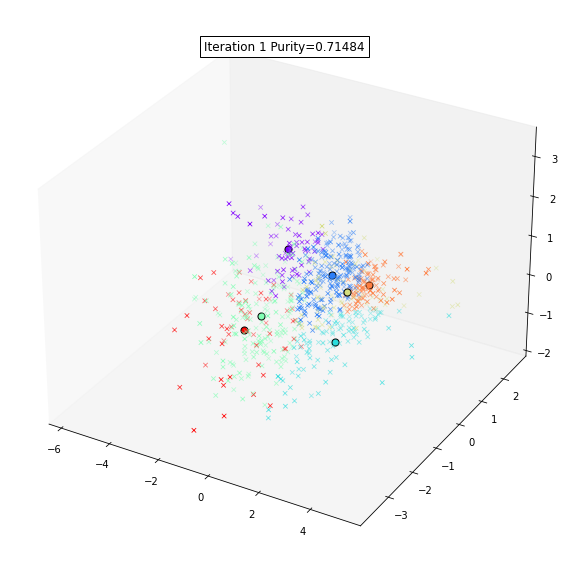

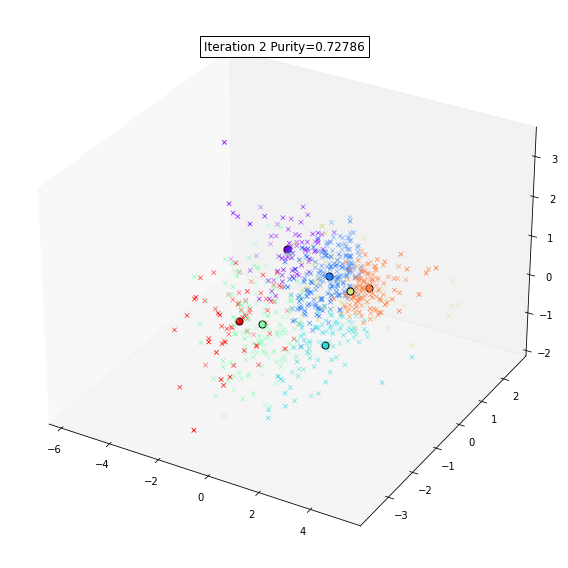

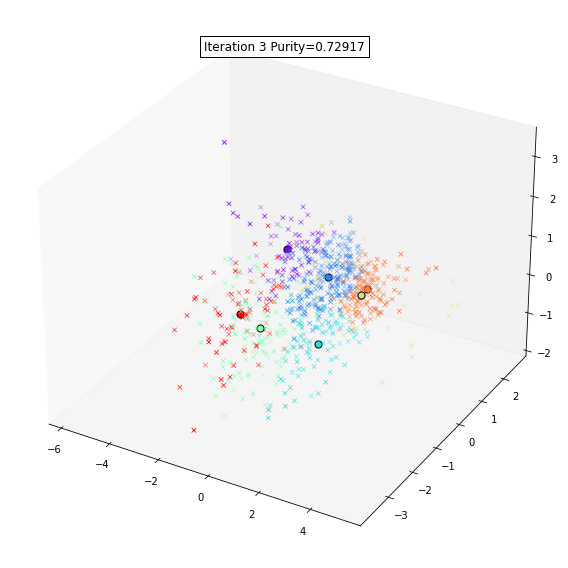

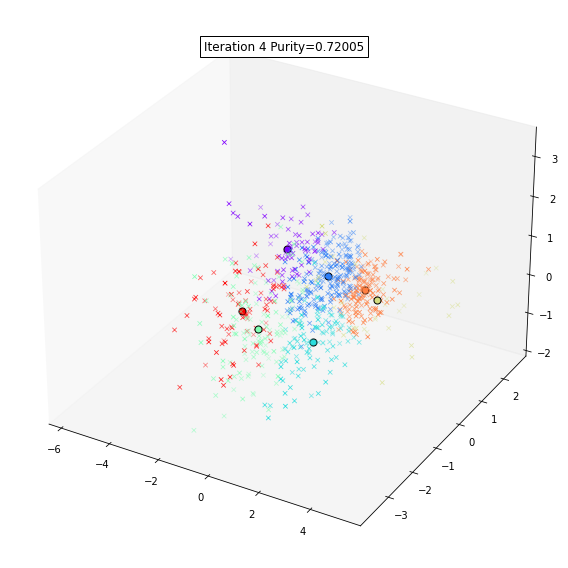

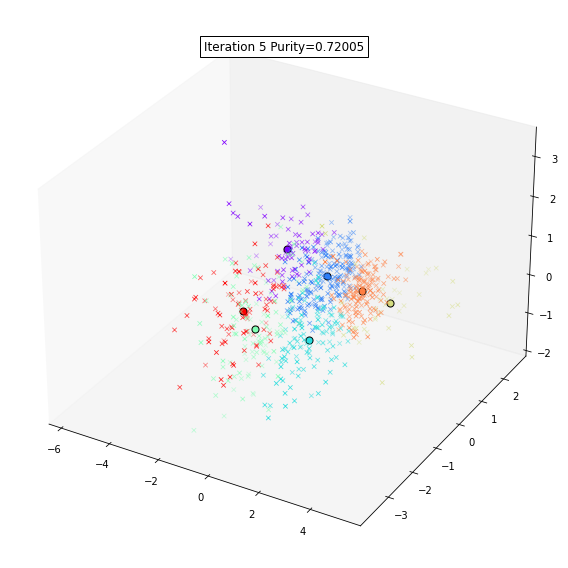

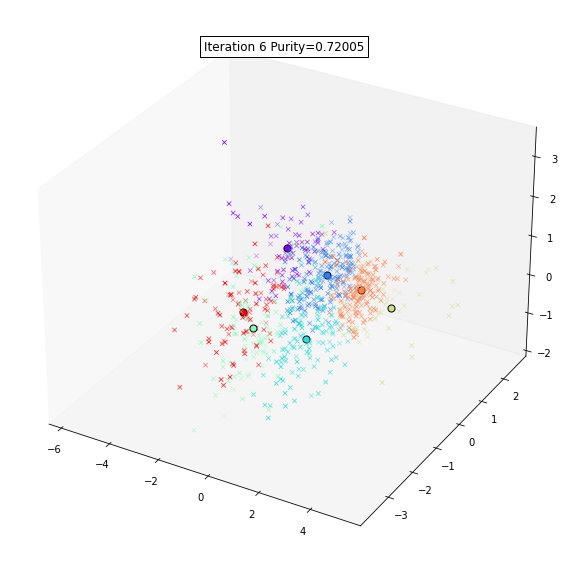

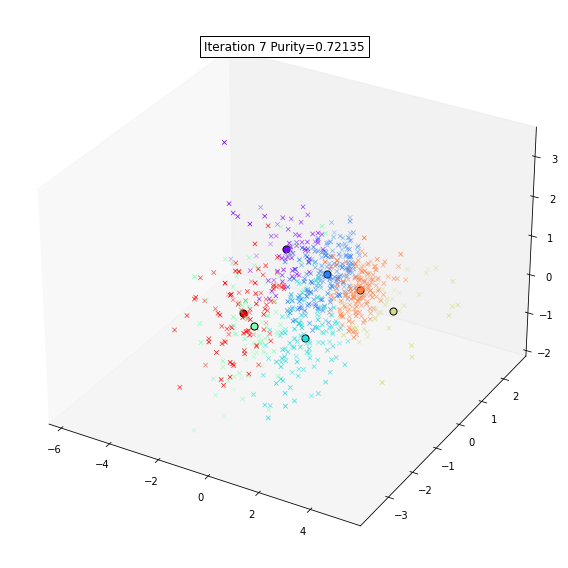

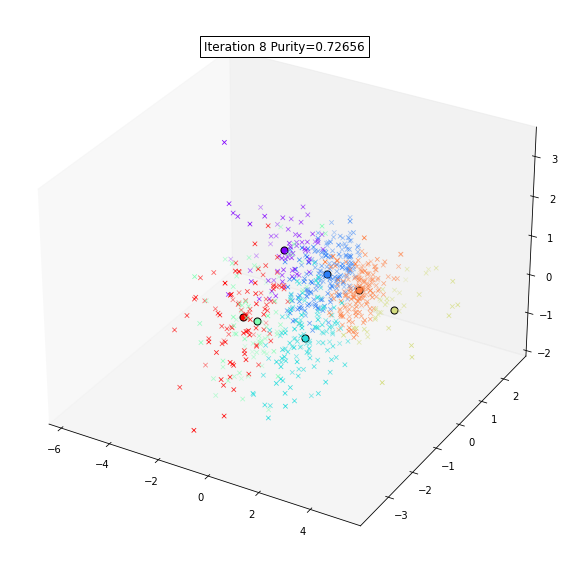

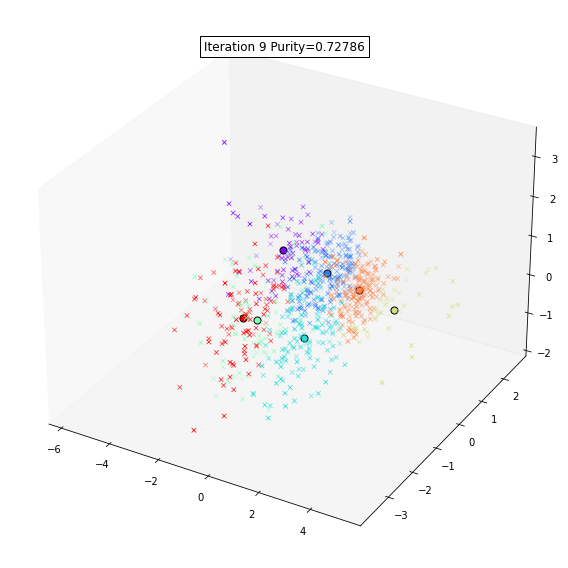

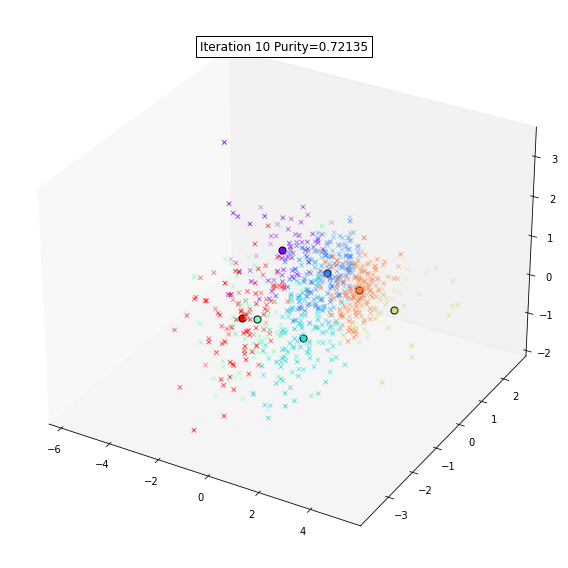

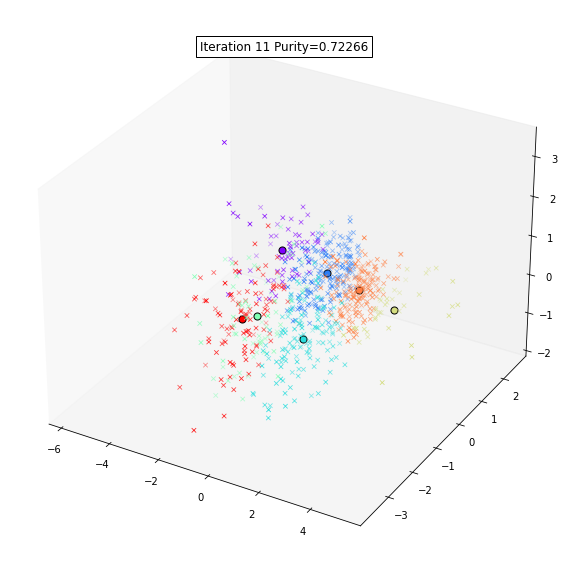

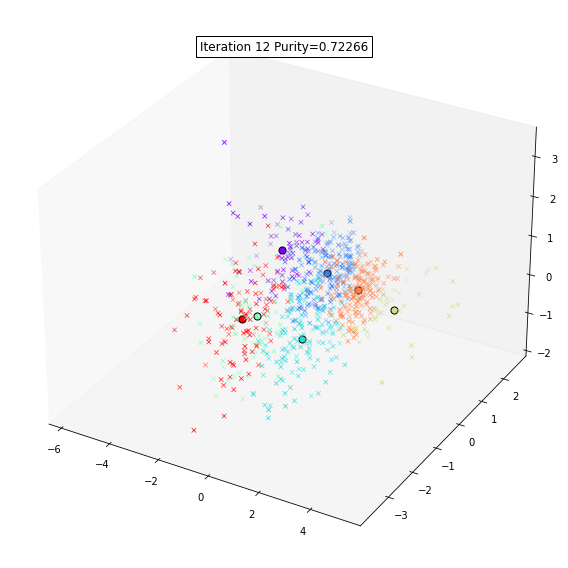

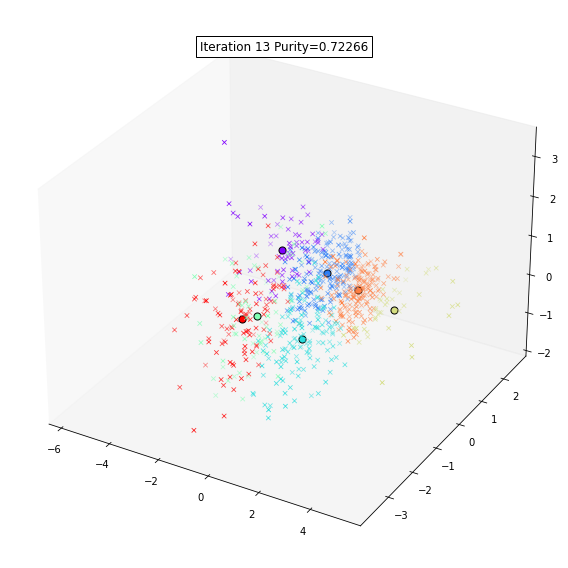

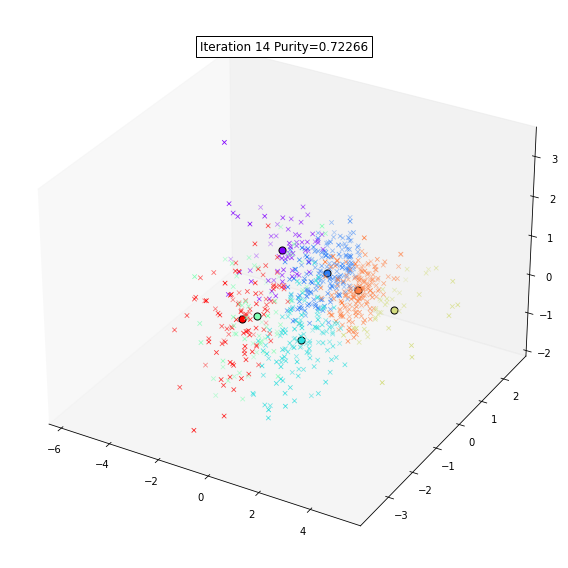

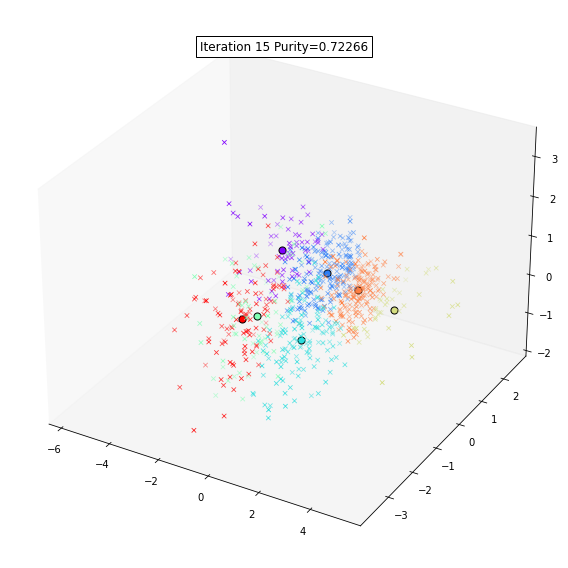

In [24]:
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from collections import Counter
import glob
from matplotlib.image import imread


# Tweak value of k here
k = 7
np.random.seed(0)
data = np.genfromtxt('diabetes.csv', delimiter=',')

# Separates the class label from the observable data to form matrices Y and X
Y, X = np.hsplit(data, [1])



# Calculate PCA
def pca(matrix, n_dim):
    # Finding covariance
    cov_mat = np.cov(matrix.T)
    
    # Finding Eigenvalues $ Eigenvectors
    eig_val, eig_vec = np.linalg.eig(cov_mat)
    eig_val, eig_vec = eig_val.real, eig_vec.real
    
    # Reducing data to n-th dim
    projected_mat = (eig_vec.T[:][0:n_dim]).T
    pca_mat = np.dot(matrix, projected_mat)
    return pca_mat


def myKmeans(data, label, k, iterations):
    """Run k-means on the supplied data and value of k"""

    samples, features = data.shape

    rnd_idx = np.random.choice(samples, k, replace=False)
    centroids = [data[_] for _ in rnd_idx]

    # Iterating over clusters
    for i in range(iterations):
        clusters, mapped_label = create_clusters(data, centroids, k)

        c_old = centroids
        centroids = get_centroids(data, clusters, features, k)

        purity = calculate_purity(clusters, mapped_label)
        data_plot(data, clusters, centroids, i + 1, k, purity)

        if termination_check(c_old, centroids, k):
            break

        

def create_clusters(data, centroids, k):
    """Generate clusters based on ref vector"""

    Y_list = Y.flatten()
    clusters = [[] for i in range(k)]
    mapped_label = [[] for i in range(k)]

    for index, sample in enumerate(data):
        c_dist = [np.linalg.norm(sample - point) for point in centroids]
        centroid_idx = np.argmin(c_dist)
        clusters[centroid_idx].append(index)
        mapped_label[centroid_idx].append(Y_list[index])

    return clusters, mapped_label

def get_centroids(data, clusters, features, k):
    centroids = np.zeros((k, features))
    for index, cluster in enumerate(clusters):
        c_mean = np.mean(data[cluster], axis=0)
        centroids[index] = c_mean
    return centroids


def termination_check(c_old, c_new, k):
    """Calculates the sum of magnitude of change of the cluster centers"""

    distances = [np.linalg.norm(c_old[i] - c_new[i]) for i in range(k)]
    return sum(distances) < 2**-23


def data_plot(data, clusters, centroids, iteration, k, purity):

    colors = cm.rainbow(np.linspace(0, 1, k))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # ax.view_init(20, 65)
    ax.grid(False)

    title = "Iteration " + str(iteration) + " Purity=" + str(round(purity, 5))
    plt.title(title, x=0.5, y=0.99, bbox=dict(facecolor=(1,1,1,1)))

    for i, index in enumerate(clusters):
        c = colors[i]
        point = data[index].T
        ax.scatter(*point, marker="x", color=c, linewidths=0.8)
        centroid_point = centroids[i]
        ax.scatter(*centroid_point, marker="o", color=c, s=50, edgecolors='black')

    
    plt.tight_layout()
    plt.rcParams["figure.figsize"] = (10,8)
    plt_filename = ".\images\q2_scatterplot_" + str(iteration).zfill(2)
    plt.savefig(plt_filename, dpi=100)

    # plt.show()


def calculate_purity(clusters, labels):
    """Calculates avg purity of clusters"""

    purity_sum = 0
    observations = 0

    for index, cluster in enumerate(clusters):
        occurences = Counter(labels[index])
        purity_sum += max(occurences.values())
        observations += len(cluster)

    purity = (1/observations) * purity_sum
    return purity


def make_video():
    """Generate video of k-means clustering"""

    image_folder = 'images'
    img_list = [f for f in glob.glob(".\images\*")]


    img = []
    for i in img_list:
        img.append(cv2.imread(i))

    # Video metadata
    height, width, layers = img[0].shape
    FPS = 0.5

    # Video codec and writer
    fourcc = VideoWriter_fourcc(*'MP42')
    video_name = "./K_" + str(k) + ".avi"
    video = VideoWriter(video_name, fourcc, float(FPS), (width, height))

    for j in img:
        video.write(j)

    video.write(img[-1])

    video.release()



# Standardizing the matrix
standardized_mat = np.array(ss.zscore(X, axis=0, ddof=1))
pca_matrix = pca(standardized_mat, 3)


myKmeans(pca_matrix, Y, k, 15)
make_video()






